In [24]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import os
import tensorflow_hub as hub
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import os
import time
from matplotlib import pyplot as plt
import cv2
import string
import unicodedata

In [54]:
new_model = load_model('models/solar_field_classifier.h5')
data_aug_model = load_model('models/solar_field_classifier_data_aug.h5')

In [44]:
#Load Data

df = pd.read_excel('Global Solar Power Tracker - main V1.xlsx', 'Europe')
df = df.loc[(df['Location accuracy']=='exact') & (df['Technology Type'] != 'Solar Thermal')&(df['Status']=='operating')]
df = df[['Country', 'Project Name', 'Capacity (MW)', 'Latitude', 'Longitude']].reset_index(drop=True)
df['Capacity (MW)'] = pd.to_numeric(df['Capacity (MW)'])
df = df.loc[df['Capacity (MW)']>5].reset_index(drop=True)



In [45]:
imagess = 'ImageFetching_2023-05-31_1417.xlsx'
previmages_df = pd.read_excel(imagess, index_col=0)
used_index = previmages_df.index.tolist()

used_df = df.index.isin(used_index)
unused_europe = df[~used_df].reset_index(drop=True)

In [15]:
for i,country, projname, cap, lat, lon in unused_europe:
    api_key = 'AmsQbXtxrmBgb0YK_x1LDIGMdCtq9YgTLfiKn76-I-QU2yGZneThmpzh4MTHT32x'
    zoom_level = 18
    map_width = 600
    map_height = 600

    lat = unused_europe.loc[244]['Latitude']
    lon = unused_europe.loc[244]['Longitude']

    api_url = f'https://dev.virtualearth.net/REST/v1/Imagery/Map/Aerial/{lat},{lon}/{zoom_level}?mapsize={map_width},{map_height}&key={api_key}'

    response = requests.get(api_url)

    image = Image.open(BytesIO(response.content))

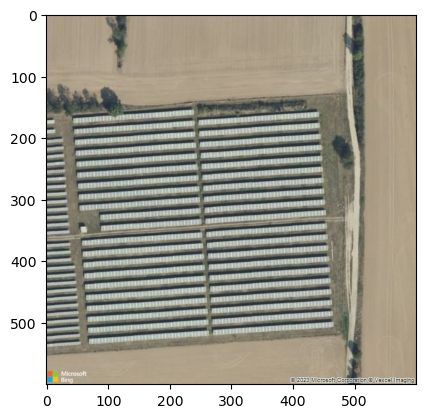

In [17]:
plt.imshow(image)
plt.show()

In [37]:
def execute_model(img):
    #make our image something the model can read
    resized = tf.image.resize(img, (256, 256))
    scaled = resized/255
    #this is to get our image into the format (batch size, 256, 256, 3) where batch size is 1
    #right now our image is in the format (256, 256, 3)
    as_batch = np.expand_dims(scaled, 0)
    
    #execute the model
    yhat = new_model.predict(as_batch)
    
    return yhat

In [74]:
def execute_dataaug_model(img):
    #make our image something the model can read
    resized = tf.image.resize(img, (256, 256))
    scaled = resized/255
    #this is to get our image into the format (batch size, 256, 256, 3) where batch size is 1
    #right now our image is in the format (256, 256, 3)
    as_batch = np.expand_dims(scaled, 0)
    
    #execute the model
    yhat = data_aug_model.predict(as_batch)
    
    return yhat

1/1 [==============================] - 0s 31ms/step


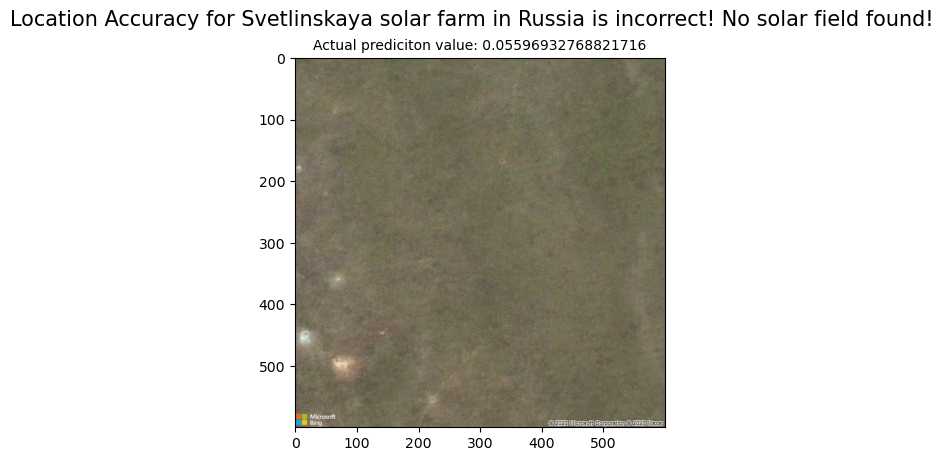

1/1 [==============================] - 0s 17ms/step


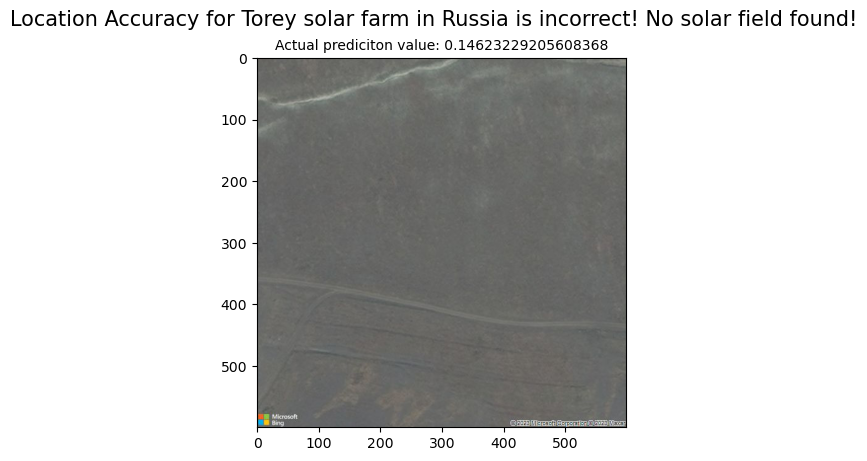

1/1 [==============================] - 0s 18ms/step


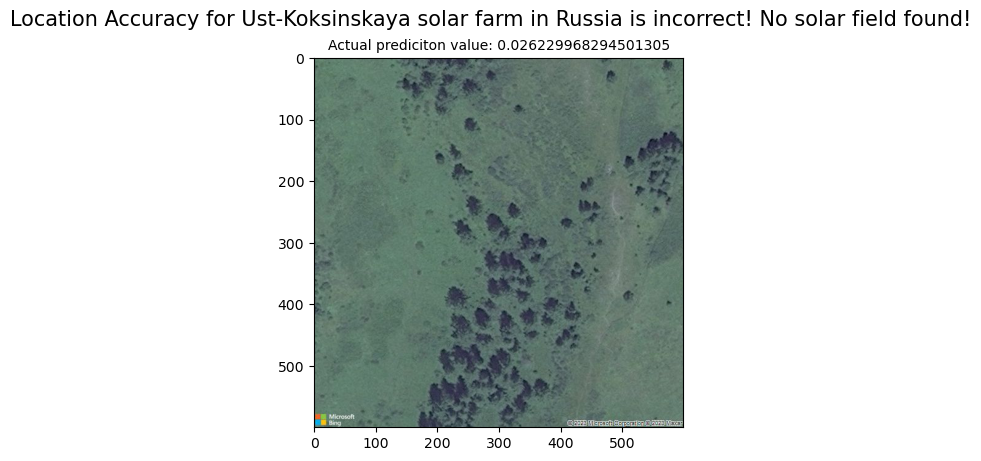

1/1 [==============================] - 0s 16ms/step


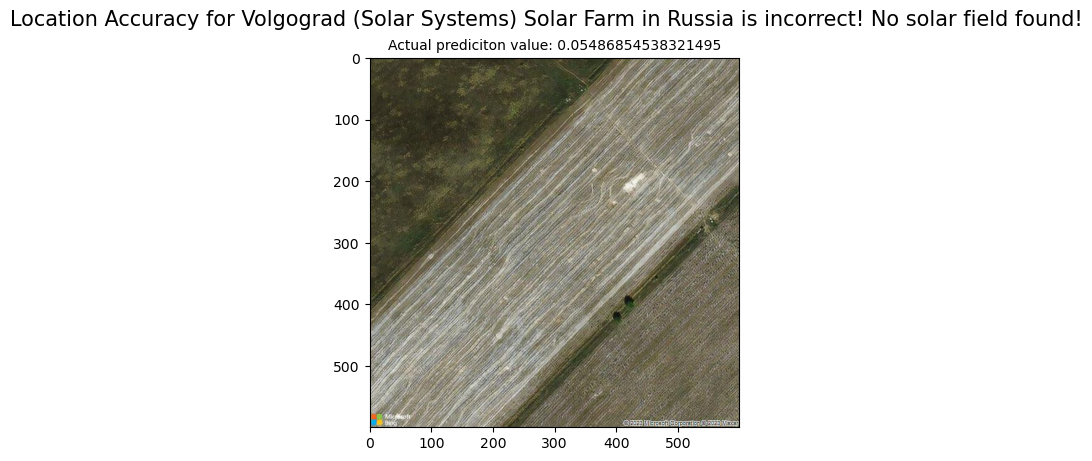

1/1 [==============================] - 0s 16ms/step


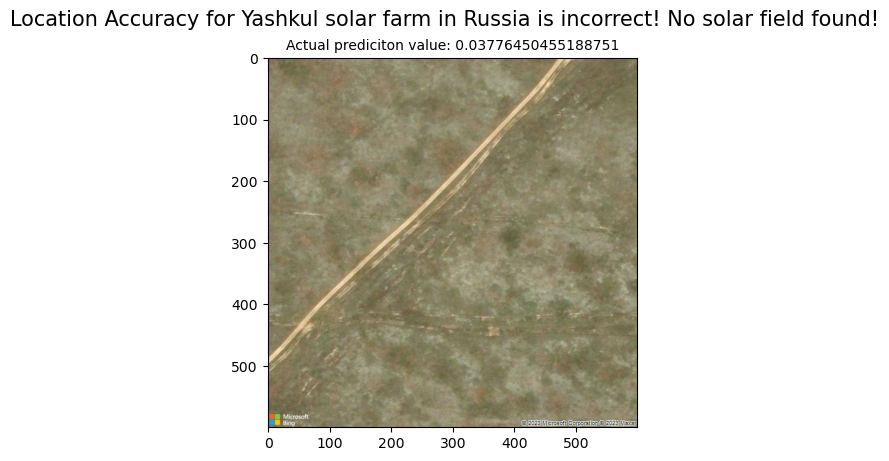

1/1 [==============================] - 0s 17ms/step


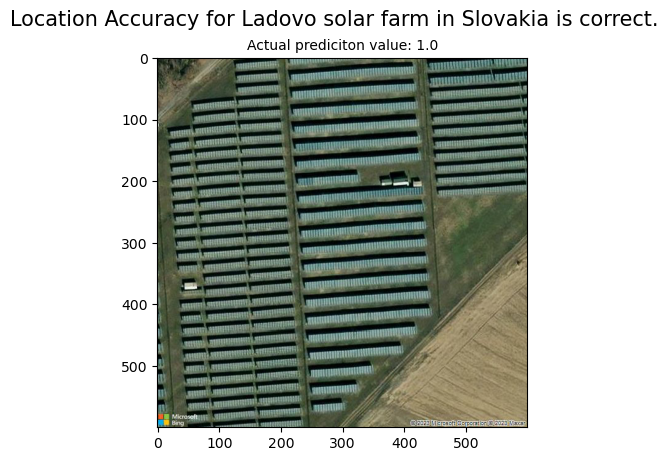

1/1 [==============================] - 0s 19ms/step


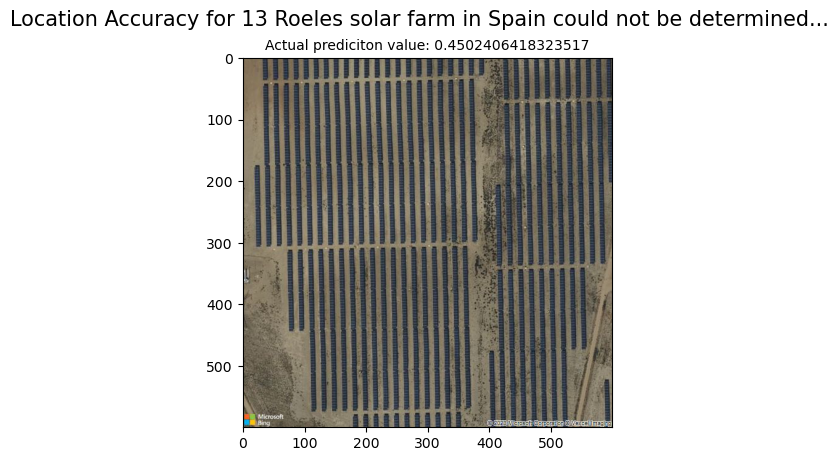

1/1 [==============================] - 0s 17ms/step


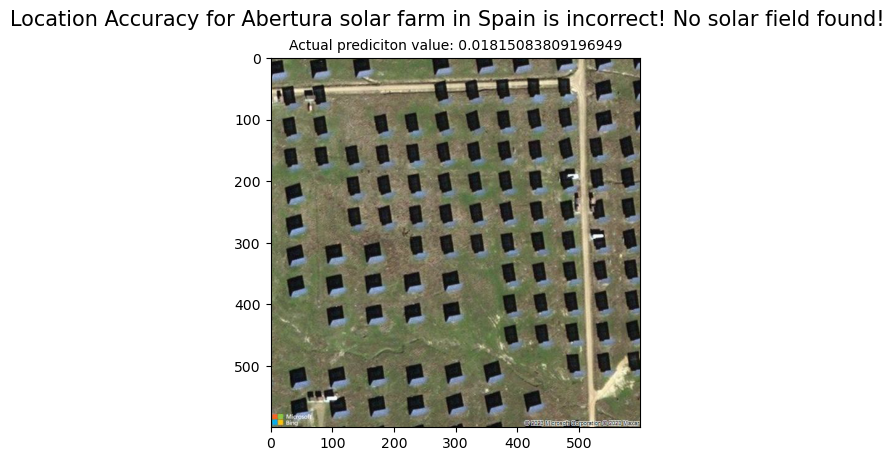

1/1 [==============================] - 0s 13ms/step


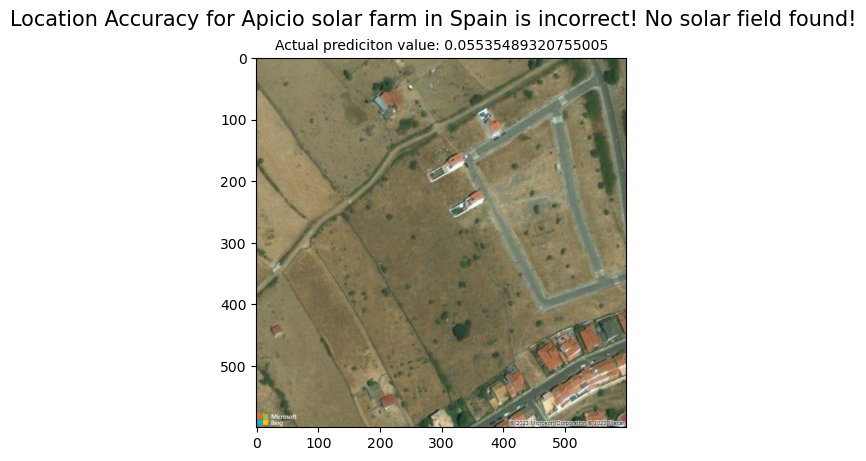

1/1 [==============================] - 0s 16ms/step


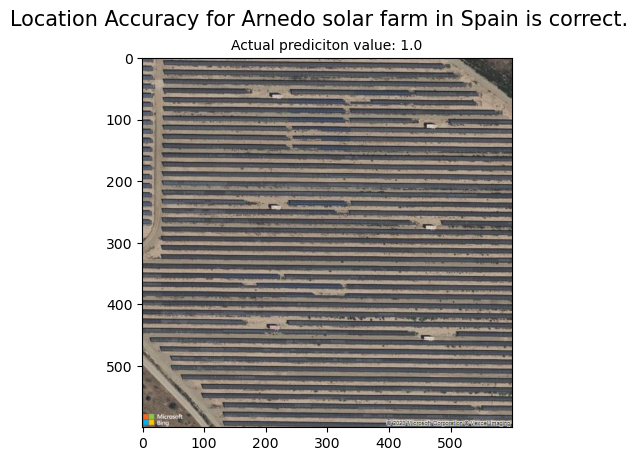

In [51]:
for i,country, projname, cap, lat, lon in unused_europe[100:110].reset_index().values:
    api_key = 'AmsQbXtxrmBgb0YK_x1LDIGMdCtq9YgTLfiKn76-I-QU2yGZneThmpzh4MTHT32x'
    zoom_level = 18
    map_width = 600
    map_height = 600

    api_url = f'https://dev.virtualearth.net/REST/v1/Imagery/Map/Aerial/{lat},{lon}/{zoom_level}?mapsize={map_width},{map_height}&key={api_key}'

    response = requests.get(api_url)

    image = Image.open(BytesIO(response.content))
    prediction = execute_model(image)
    
     
    if prediction > 0.7:
        #print(f'Location Accuracy for {projname} in {country} is correct. | Actual prediciton value: {prediction[0][0]}')
        plt.imshow(image)
        plt.suptitle(f'Location Accuracy for {projname} in {country} is correct.', fontsize=15)
        plt.title(f'Actual prediciton value: {prediction[0][0]}', fontsize=10)
        plt.show()
    elif prediction < 0.3:
        #print(f'Location Accuracy for {projname} in {country} is incorrect! No solar field found! | Actual prediciton value: {prediction[0][0]}')
        plt.imshow(image)
        plt.suptitle(f'Location Accuracy for {projname} in {country} is incorrect! No solar field found!', fontsize=15)
        plt.title(f'Actual prediciton value: {prediction[0][0]}', fontsize=10)
        plt.show()
    else:
        #print(f'Location Accuracy for {projname} in {country} could not be determined... | Actual prediciton value: {prediction[0][0]}')
        plt.imshow(image)
        plt.suptitle(f'Location Accuracy for {projname} in {country} could not be determined...', fontsize=15)
        plt.title(f'Actual prediciton value: {prediction[0][0]}', fontsize=10)
        plt.show()        

In [62]:
results2 = []
for i,country, projname, cap, lat, lon in unused_europe.reset_index().values:
    api_key = 'AmsQbXtxrmBgb0YK_x1LDIGMdCtq9YgTLfiKn76-I-QU2yGZneThmpzh4MTHT32x'
    zoom_level = 18
    map_width = 600
    map_height = 600

    api_url = f'https://dev.virtualearth.net/REST/v1/Imagery/Map/Aerial/{lat},{lon}/{zoom_level}?mapsize={map_width},{map_height}&key={api_key}'

    response = requests.get(api_url)

    image = Image.open(BytesIO(response.content))
    prediction = execute_dataaug_model(image)
    
     
    if prediction > 0.7:
        result = 'CORRECT'
        results2.append([i, country, projname, cap, lat, lon, result, prediction, image])
        #print(f'Location Accuracy for {projname} in {country} is correct. | Actual prediciton value: {prediction[0][0]}')

    elif prediction < 0.3:
        result = 'INCORRECT'
        results2.append([i, country, projname, cap, lat, lon, result, prediction, image])
        #print(f'Location Accuracy for {projname} in {country} is incorrect! No solar field found! | Actual prediciton value: {prediction[0][0]}')

    else:
        result = 'UNCERTAIN'
        results2.append([i, country, projname, cap, lat, lon, result, prediction, image])
        #print(f'Location Accuracy for {projname} in {country} could not be determined... | Actual prediciton value: {prediction[0][0]}')


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


In [58]:
results1_df = pd.DataFrame(results, columns=['Index', 'Country', 'Project Name', 'Capacity', 'Latitude', 'Longitude', 'Location Accuracy Assessment', 'Prediction Value', 'Image Data'])
results1_df

Index         Country                                       Project Name  \
0        0         Germany  LHI Solar Deutschland V GmbH & Co. KG II solar...   
1        1         Germany  LHI Solar Deutschland VI GmbH & Co. KG (PVA We...   
2        2         Germany  LHI Solar Deutschland VI GmbH & Co. KG (PVA We...   
3        3         Germany        LHI Solar Prenzlau GmbH & Co. KG solar farm   
4        4         Germany  LHI SolarWind Euerwang GmbH & Co. KG (Erweiter...   
..     ...             ...                                                ...   
737    737  United Kingdom                      Wroughton Airfield Solar Park   
738    738  United Kingdom                      Wymeswold Airfield solar farm   
739    739  United Kingdom                     Yarburgh Grove Farm solar farm   
740    740  United Kingdom                     Yerbeston Gate Farm solar farm   
741    741  United Kingdom                                    York solar farm   

     Capacity Latitude Longitude Location Accuracy Assessment Prediction Value  
0         7.0  53.5508   12.5691                      CORRECT   [[0.99999976]]  
1         5.6  51.5910   14.1392                      CORRECT          [[1.0]]  
2         9.8  51.5910   14.1392                      CORRECT          [[1.0]]  
3        13.0  53.3172   13.8817                      CORRECT          [[1.0]]  
4         5.9  49.0090   11.3445                    INCORRECT  [[0.015827628]]  
..        ...      ...       ...                          ...              ...  
737      61.0  51.5104   -1.8124                    INCORRECT  [[0.092553265]]  
738      34.0  52.8033   -1.1116                    INCORRECT   [[0.06751854]]  
739       8.1  53.4075    0.0188                    INCORRECT  [[0.055189714]]  
740       6.1  51.7473   -4.7945                    INCORRECT   [[0.29968986]]  
741      35.0  54.1445   -1.2281                    INCORRECT   [[0.01294412]]  

[742 rows x 8 columns]

In [63]:
results2_df = pd.DataFrame(results2, columns=['Index', 'Country', 'Project Name', 'Capacity', 'Latitude', 'Longitude', 'Location Accuracy Assessment', 'Prediction Value', 'Image Data'])
results2_df

Index         Country                                       Project Name  \
0        0         Germany  LHI Solar Deutschland V GmbH & Co. KG II solar...   
1        1         Germany  LHI Solar Deutschland VI GmbH & Co. KG (PVA We...   
2        2         Germany  LHI Solar Deutschland VI GmbH & Co. KG (PVA We...   
3        3         Germany        LHI Solar Prenzlau GmbH & Co. KG solar farm   
4        4         Germany  LHI SolarWind Euerwang GmbH & Co. KG (Erweiter...   
..     ...             ...                                                ...   
737    737  United Kingdom                      Wroughton Airfield Solar Park   
738    738  United Kingdom                      Wymeswold Airfield solar farm   
739    739  United Kingdom                     Yarburgh Grove Farm solar farm   
740    740  United Kingdom                     Yerbeston Gate Farm solar farm   
741    741  United Kingdom                                    York solar farm   

     Capacity Latitude Longitude Location Accuracy Assessment  \
0         7.0  53.5508   12.5691                      CORRECT   
1         5.6  51.5910   14.1392                      CORRECT   
2         9.8  51.5910   14.1392                      CORRECT   
3        13.0  53.3172   13.8817                      CORRECT   
4         5.9  49.0090   11.3445                    INCORRECT   
..        ...      ...       ...                          ...   
737      61.0  51.5104   -1.8124                    UNCERTAIN   
738      34.0  52.8033   -1.1116                    INCORRECT   
739       8.1  53.4075    0.0188                    INCORRECT   
740       6.1  51.7473   -4.7945                    INCORRECT   
741      35.0  54.1445   -1.2281                    INCORRECT   

     Prediction Value                                         Image Data  
0      [[0.99999714]]  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
1             [[1.0]]  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
2             [[1.0]]  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
3             [[1.0]]  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
4    [[0.0041029323]]  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
..                ...                                                ...  
737    [[0.37991944]]  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
738  [[0.0034955002]]  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
739    [[0.26631212]]  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
740    [[0.02380231]]  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
741   [[0.021920461]]  <PIL.JpegImagePlugin.JpegImageFile image mode=...  

[742 rows x 9 columns]

In [59]:
results1_df['Location Accuracy Assessment'].value_counts()

CORRECT      356
INCORRECT    349
UNCERTAIN     37
Name: Location Accuracy Assessment, dtype: int64

In [61]:
results2_df['Location Accuracy Assessment'].value_counts()

INCORRECT    383
CORRECT      330
UNCERTAIN     29
Name: Location Accuracy Assessment, dtype: int64

1/1 [==============================] - 0s 20ms/step


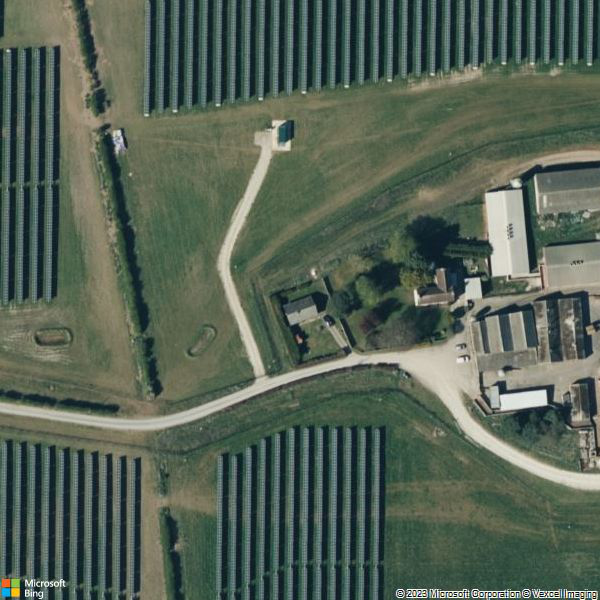

In [77]:

test = results2_df['Image Data'].iloc[[741]].values[0]
execute_dataaug_model(test)

test